In [546]:
import numpy as np
import pandas as pd
import re
import pydot
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os.path
from os import path

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont


In [547]:
df_train = pd.read_csv('../input/train.csv');
df_test = pd.read_csv('../input/test.csv')
entiredata = [df_train, df_test]
originaltraindata = df_train.copy()
PassengerId  = df_test['PassengerId']
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [548]:
df_train.info()
df_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [549]:
df_train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Garfirth, Mr. John",male,347082,B96 B98,S
freq,1,577,7,4,644


In [550]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [551]:
df_train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


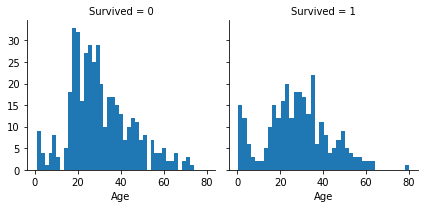

In [552]:
g = sns.FacetGrid(df_train, col='Survived')
g.map(plt.hist, 'Age', bins=40)

C:\Users\priya\anaconda3\lib\site-packages\seaborn\axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


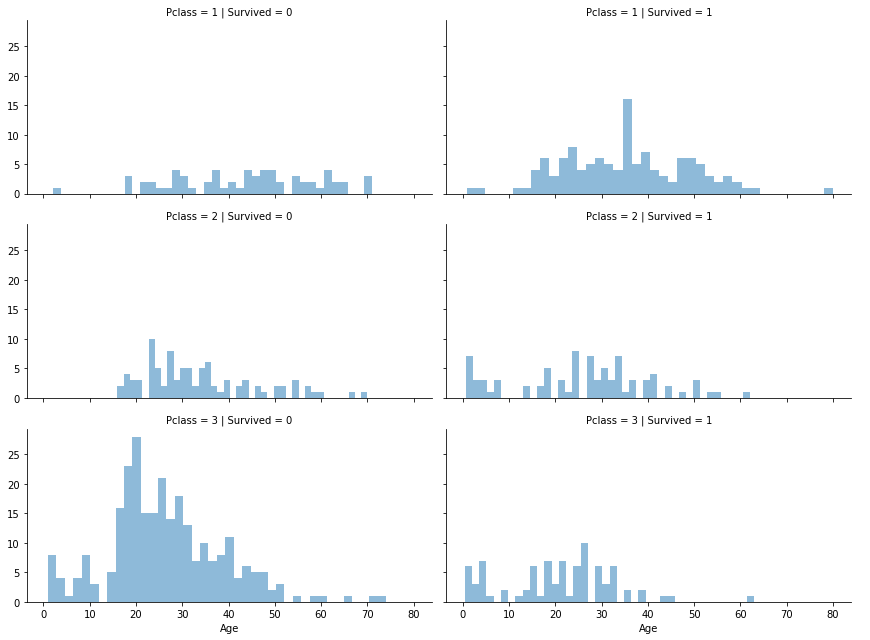

In [553]:
grid = sns.FacetGrid(df_train, col='Survived', row='Pclass', size=3, aspect=2)
grid.map(plt.hist, 'Age', alpha=.5, bins=40)
grid.add_legend();

C:\Users\priya\anaconda3\lib\site-packages\seaborn\axisgrid.py:728: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


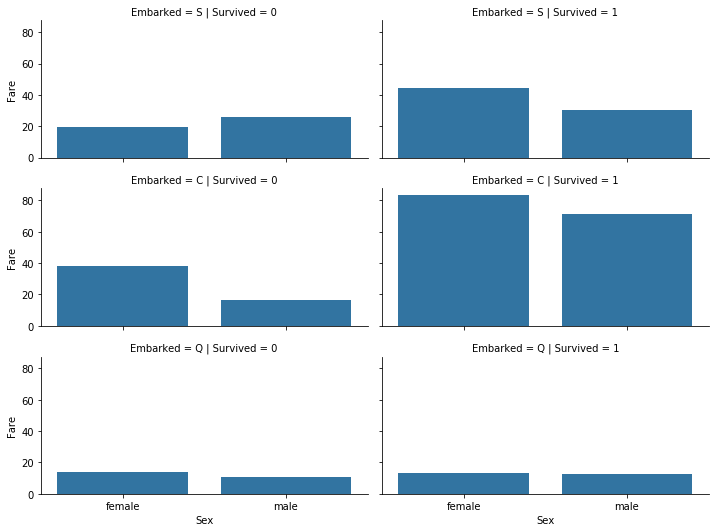

In [554]:
grid = sns.FacetGrid(df_train, row='Embarked', col='Survived', size=2.5, aspect=2)
grid.map(sns.barplot, 'Sex', 'Fare', ci=None)
grid.add_legend()

In [555]:
#creating a new feature family and isalone
for data in entiredata:
    data['family'] = data['SibSp'] + data['Parch'] 

for data in entiredata:
    data['isalone'] = 0
    data.loc[data['family'] == 0, 'isalone'] = 1
df_train.head()
    

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family,isalone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,1


In [556]:
# Adding titles
def title(name):
    search_title = re.search(' ([A-Za-z]+)\.', name)
    # etract the title if exists and return
    if search_title:
        return search_title.group(1)
    return ""

for data in entiredata:
    data['Title'] = data['Name'].apply(title)
for data in entiredata:
    data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    data['Title'] = data['Title'].replace('Mlle', 'Miss')
    data['Title'] = data['Title'].replace('Ms', 'Miss')
    data['Title'] = data['Title'].replace('Mme', 'Mrs')


In [557]:
# mapping titles
for data in entiredata:
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    data['Title'] = data['Title'].map(title_mapping)
    data['Title'] = data['Title'].fillna(0)

In [558]:
#missing details 
missing_train = df_train.isnull().sum()
missing_test = df_test.isnull().sum()
missing_test


PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
family           0
isalone          0
Title            0
dtype: int64

In [559]:
missing_train

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
family           0
isalone          0
Title            0
dtype: int64

In [560]:
# Removing Nulls from Embarked, fare
for data in entiredata:
    data['Embarked'] = data['Embarked'].fillna(df_train.Embarked.dropna().mode()[0])
for data in entiredata:
    data['Fare'] = data['Fare'].fillna(df_train['Fare'].median())

In [561]:
# mapping gender female:1 male:0
for data in entiredata:
    data['Sex'] = data['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

In [562]:
#Removing nulls from age
pred_ages = np.zeros((2,3))
pred_ages

array([[0., 0., 0.],
       [0., 0., 0.]])

In [563]:
for data in entiredata:
    for i in range(0, 2):
        for j in range(0, 3):
            pred_df = data[(data['Sex'] == i) & \
                                  (data['Pclass'] == j+1)]['Age'].dropna()
            age_pred = pred_df.median()
            pred_ages[i,j] = int( age_pred/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            data.loc[ (data.Age.isnull()) & (data.Sex == i) & (data.Pclass == j+1),\
                    'Age'] = pred_ages[i,j]

    data['Age'] = data['Age'].astype(int)

df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family,isalone,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,22,1,0,A/5 21171,7.2500,NaN,S,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,PC 17599,71.2833,C85,C,1,0,3
2,3,1,3,"Heikkinen, Miss. Laina",1,26,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,4
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,113803,53.1000,C123,S,1,0,3
4,5,0,3,"Allen, Mr. William Henry",0,35,0,0,373450,8.0500,NaN,S,0,1,1


In [564]:
# Mapping Age, fare , Embarked
for data in entiredata:
    data.loc[ data['Age'] <= 16, 'Age']    = 0
    data.loc[(data['Age'] > 16) & (data['Age'] <= 32), 'Age'] = 1
    data.loc[(data['Age'] > 32) & (data['Age'] <= 48), 'Age'] = 2
    data.loc[(data['Age'] > 48) & (data['Age'] <= 64), 'Age'] = 3
    data.loc[ data['Age'] > 64, 'Age'] = 4
    
    data.loc[ data['Fare'] <= 7.91, 'Fare'] = 0
    data.loc[(data['Fare'] > 7.91) & (data['Fare'] <= 14.454), 'Fare'] = 1
    data.loc[(data['Fare'] > 14.454) & (data['Fare'] <= 31), 'Fare']   = 2
    data.loc[ data['Fare'] > 31, 'Fare'] = 3
    data['Fare'] = data['Fare'].astype(int)
    
    data['Embarked'] = data['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

In [565]:
# Feature Selection : Removing irrelavant features
drop_features = ['PassengerId', 'Name', 'Ticket', 'Cabin']
df_train = df_train.drop(drop_features, axis = 1)
df_test = df_test.drop(drop_features, axis = 1)

df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,family,isalone,Title
0,0,3,0,1,1,0,0,0,1,0,1
1,1,1,1,2,1,0,3,1,1,0,3
2,1,3,1,1,0,0,1,0,0,1,4
3,1,1,1,2,1,0,3,0,1,0,3
4,0,3,0,2,0,0,1,0,0,1,1


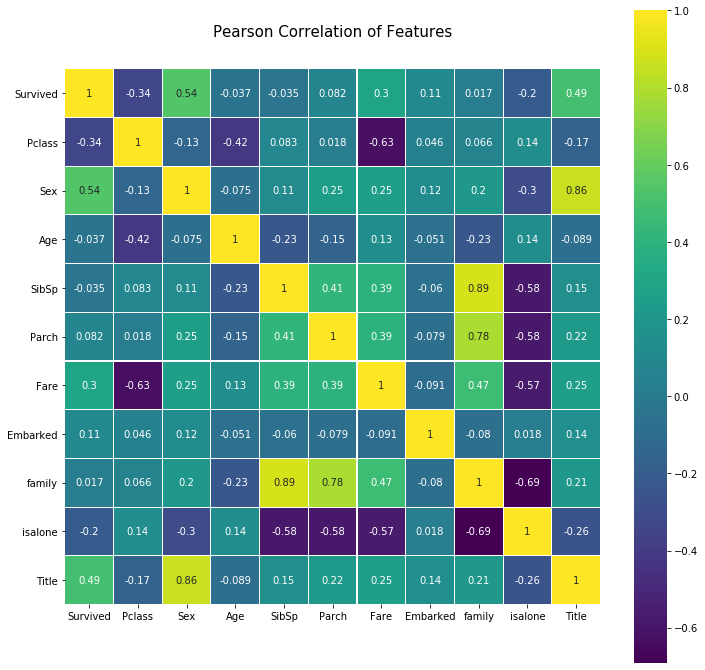

In [566]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df_train.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [567]:
# tite and gender ; title is more releavnt than gender/sex
df_train[['Title', 'Survived']].groupby(['Title'], as_index=False).agg(['mean', 'count', 'sum'])

Survived           
           mean count  sum
Title                     
1      0.156673   517   81
2      0.575000    40   23
3      0.793651   126  100
4      0.702703   185  130
5      0.347826    23    8

In [568]:
df_train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).agg(['mean', 'count', 'sum'])

Survived           
         mean count  sum
Sex                     
0    0.188908   577  109
1    0.742038   314  233

In [569]:
tempdata = originaltraindata.copy()[['Name', 'Sex']]

tempdata['Title'] = tempdata['Name'].apply(title)
tempdata['Sex'] = tempdata['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

tempdata[['Title', 'Sex']].groupby(['Title'], as_index=False).agg(['mean', 'count', 'sum'])

Sex           
              mean count  sum
Title                        
Capt      1.000000     1    1
Col       1.000000     2    2
Countess  0.000000     1    0
Don       1.000000     1    1
Dr        0.857143     7    6
Jonkheer  1.000000     1    1
Lady      0.000000     1    0
Major     1.000000     2    2
Master    1.000000    40   40
Miss      0.000000   182    0
Mlle      0.000000     2    0
Mme       0.000000     1    0
Mr        1.000000   517  517
Mrs       0.000000   125    0
Ms        0.000000     1    0
Rev       1.000000     6    6
Sir       1.000000     1    1

In [570]:
# defining gini 
def gini_impurity(count_survived,count_total):
    prob_survival = count_survived/count_total
    prob_not_survival = (1 - prob_survival)
    prob_survival_random = prob_survival
    prob_not_survival_random= (1 - prob_survival_random)
    prob_survival_mislabelling = prob_not_survival * prob_survival_random
    prob_not_survival_mislabelling = prob_survival * prob_not_survival_random
    gini_impurity = prob_survival_mislabelling + prob_not_survival_mislabelling
    return gini_impurity

In [571]:
df_train.groupby('Survived').count()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,family,isalone,Title
Survived,,,,,,,,,,
0,549,549,549,549,549,549,549,549,549,549
1,342,342,342,342,342,342,342,342,342,342


In [572]:
starting_node_gini_impurity = gini_impurity(342, 891)
starting_node_gini_impurity 

0.47301295786144265

In [573]:
# gini impurity for sex
men_gini_impurity = gini_impurity(109, 577)
women_gini_impurity = gini_impurity(233, 314)
weight_men = 577/891
weight_women = 314/891
gini_impurity_weighted = ( men_gini_impurity * weight_men) +(women_gini_impurity * weight_women)
dec_gini = gini_impurity_weighted - starting_node_gini_impurity
dec_gini

-0.13964795747285214

In [574]:
# gini impurity for title & title is best choice for initial node
title1_gini_impurity = gini_impurity(81, 517)
other_title_gini_impurity = gini_impurity(261, 374)
weight_title1 = 517/891
weight_other_title = 374/891
gini_impurity_title = ( title1_gini_impurity * weight_title1) +(weight_other_title * weight_other_title)
title_dec_gini = gini_impurity_title - starting_node_gini_impurity
title_dec_gini

-0.143488143233429

In [575]:
# 5 fold cross validation 
cv = KFold(n_splits=5)           
accuracies = list()
max_attributes = len(list(df_test))
depth_range = range(1, max_attributes + 1)

for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(max_depth = depth)
    for train_fold, valid_fold in cv.split(df_train):
        f_train = df_train.loc[train_fold] 
        f_valid = df_train.loc[valid_fold] 
        model = tree_model.fit(X = f_train.drop(['Survived'], axis=1), 
                               y = f_train["Survived"])
        valid_acc = model.score(X = f_valid.drop(['Survived'], axis=1), 
                                y = f_valid["Survived"])
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.778909
         2          0.787898
         3          0.824882
         4          0.824889
         5          0.817030
         6          0.815956
         7          0.810338
         8          0.790120
         9          0.796868
        10          0.797985


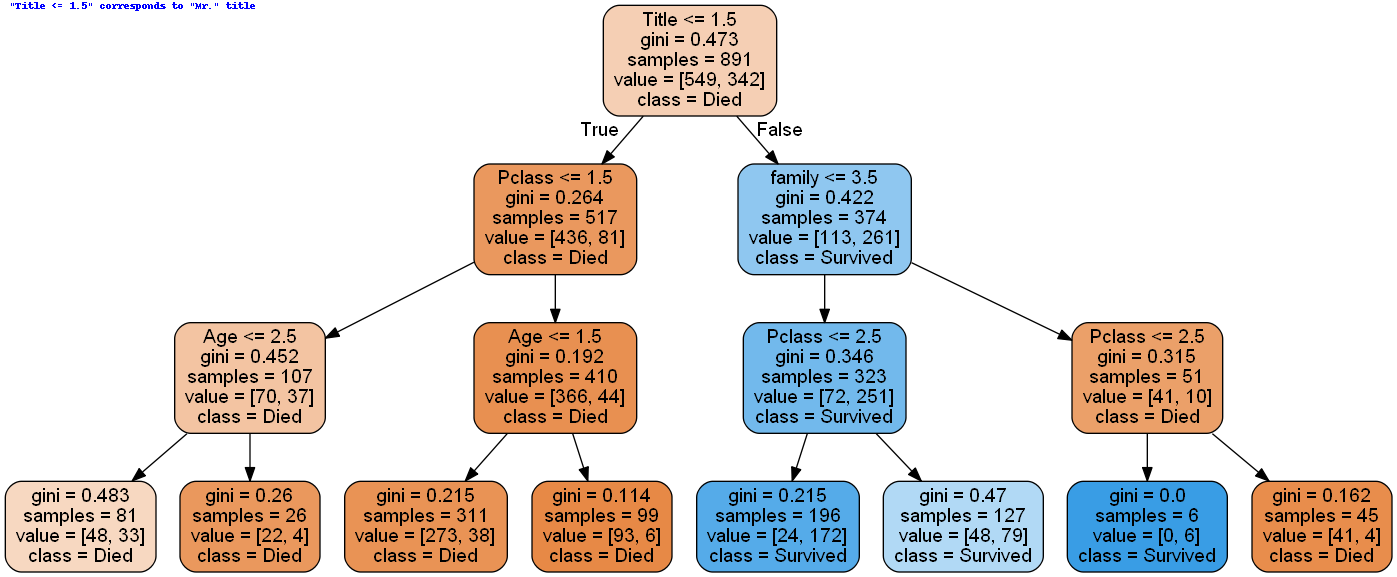

In [576]:
y_train = df_train['Survived']
x_train = df_train.drop(['Survived'], axis=1).values 
x_test = df_test.values

# Create Decision Tree with max_depth = 3
decision_tree = tree.DecisionTreeClassifier(max_depth = 3)
decision_tree.fit(x_train, y_train)

# Predicting results for test dataset
y_pred = decision_tree.predict(x_test)
submission = pd.DataFrame({
       "PassengerId": PassengerId,
        "Survived": y_pred
        
    })
submission.to_csv('submission.csv', index=False)


with open("tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 4,
                              impurity = True,
                              feature_names = list(df_train.drop(['Survived'], axis=1)),
                              class_names = ['Died', 'Survived'],
                              rounded = True,
                              filled= True )
        
(graph,) = pydot.graph_from_dot_file('tree1.dot')
graph.write_png('tree1.png')

img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
font = ImageFont.load_default()
draw.text((10, 0), # Drawing offset (position)
          '"Title <= 1.5" corresponds to "Mr." title', # Text to draw
          (0,0,255), # RGB desired color
          font=font) # ImageFont object with desired font
img.save('sample-out.png')
PImage("sample-out.png")


In [577]:
decisiontree_accu = round(decision_tree.score(x_train, y_train) * 100, 2)
decisiontree_accu

82.38

In [578]:
columns = df_test.columns
feature_importances = pd.DataFrame(decision_tree.feature_importances_,
                                   index = columns,
                                    columns=['importance'])
feature_importances.sort_values(by='importance', ascending=False).head(10)

,importance
Title,0.674515
family,0.157791
Pclass,0.151243
Age,0.016451
Sex,0.000000
SibSp,0.000000
Parch,0.000000
Fare,0.000000
Embarked,0.000000
isalone,0.000000


In [579]:
# random forest
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
n_estimators = [140,145,150,155,160];
max_depth = range(1,10);
criterions = ['gini', 'entropy'];
cv = StratifiedShuffleSplit(n_splits=5, test_size=.30, random_state=15)


parameters = {'n_estimators':n_estimators,
              'max_depth':max_depth,
              'criterion': criterions
              
        }
grid = GridSearchCV(estimator=RandomForestClassifier(max_features='auto'),
                                 param_grid=parameters,
                                 cv=cv,
                                 n_jobs = -1)
grid.fit(x_train, y_train) 



GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=15, test_size=0.3,
            train_size=None),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
       

In [580]:
print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)

0.8343283582089553
{'criterion': 'gini', 'max_depth': 4, 'n_estimators': 140}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=140,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [581]:
rf_grid = grid.best_estimator_
rf_grid.score(x_train, y_train)

0.8338945005611672

In [582]:
feature_importances1= pd.DataFrame(rf_grid.feature_importances_,
                                   index = columns,
                                    columns=['importance'])
feature_importances1.sort_values(by='importance', ascending=False).head(10)

,importance
Title,0.359334
Sex,0.272214
Pclass,0.134866
family,0.073802
Fare,0.066405
SibSp,0.028992
Age,0.022902
Parch,0.016405
Embarked,0.014286
isalone,0.010793
